In [137]:
!pip install nltk gensim

In [138]:
import pandas as pd
import time
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords
from groq import Groq
import os
from dotenv import load_dotenv
from nltk.tokenize import sent_tokenize
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oskarroeske/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# EDA

In [139]:
df_reports = pd.read_csv("preprocessed_reports.csv")
df_paragraphs = pd.read_csv("preprocessed_paragraphs.csv")

In [140]:
df_paragraphs_testing = df_paragraphs

In [141]:
df_paragraphs_testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12234 entries, 0 to 12233
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    12234 non-null  int64 
 1   document_id   12234 non-null  int64 
 2   paragraph_id  12234 non-null  int64 
 3   paragraph     12234 non-null  object
dtypes: int64(3), object(1)
memory usage: 382.4+ KB


In [142]:
df_paragraphs_testing.value_counts("document_id")

document_id
468    255
664    196
433    138
681    135
270    123
      ... 
779      1
901      1
53       1
804      1
219      1
Name: count, Length: 921, dtype: int64

In [143]:
def clean_text_again(text):
    text = strip_tags(text)
    text = strip_multiple_whitespaces(text)  # Normalize whitespaces
    return text

In [144]:
#df_paragraphs_testing["paragraphs"] = df_paragraphs_testing["paragraphs"].apply(clean_text_again)

# FINBERT

# KeyBERT

# LLM Argument Mining

- Provide List of pre-defined arguments

In [229]:
df_evaluation = pd.read_csv("evaluation_sentences.csv")

In [230]:
list_of_arguments = [
    "Earnings per Share",
    "Cash Flow",
    "Revenue",
    "Return On Equity",
    "Margins",
    "Cost Management",
    "Dividend Policy",
    "Investments",
    "Balance Sheet",
    "Long-term Growth",
    "Merges and Acquisition",
    "Refranchising",
    "Sustainability",
    "Employees",
    "Research and Development",
    "Marketing",
    "Shares Repurchase",
    "Processes",
    "Leadership",
    "Innovation",
    "Product Characteristics",
    "Pricing Strategy",
    "Production",
    "Technology Trends",
    "Market Share",
    "Market Expansion",
    "Competitors",
    "Global Presence",
    "Industry Outlook",
    "Regulations",
    "Partnerships and Collaborations",
    "Supply Chain",
    "Economic Conditions",
    "Demand",
    "Customer"
]


# Testing Start

In [231]:
#list_of_arguments = ["Financial Performance","Revenue Growth"]
# paragraph removed from instructions: - New categories must be generic, concise (max 3 words), and included in the output for list updates.
"""You will classify financial text into predefined categories or create a new one if needed:
- Assign arguments to the best-matching category. Create a new category only if no match fits.
- IGNORE brand names/Target Prices/Recommendations/Valuation as arguments.
- Classify each argument as positive, negative, or neutral.
- Include new categories in the output.
- Return only the JSON dictionary, no extra text.

In system_content: Categories: [{categories_string}]
"""


def find_arguments(text, api_key):
    client = Groq(api_key=api_key)

    categories_string = ', '.join(f'"{cat}"' for cat in list_of_arguments)

    system_content = f"""You will classify financial sentences into predefined categories or create a new one if needed:
- Assign arguments to the best-matching category. Create a new category only if no match fits.
- IGNORE brand names/Target Prices/Recommendations/Valuation as arguments.
- If no meaningful argument is mentioned in the text, return "None"
- Include new categories in the output.
- Return only the best-fitting category as a String
- Print only the result! No other text!
Categories: [{categories_string}]
"""
    
    final_prompt = f"""
        Text: {text}
       """

    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_content,
            },
            {
                "role": "user",
                "content": final_prompt,
            }
        ],
        temperature=0,
        model="llama3-70b-8192",
    )

    return response.choices[0].message.content

In [232]:
import json
from itertools import cycle

# Load API key
load_dotenv()

api_keys = [
    os.getenv("GROQ_API_KEY"),
    os.getenv("GROQ_API_KEY2"),
]

# Create a round-robin iterator for API keys
api_key_cycle = cycle(api_keys)

def get_next_api_key():
    return next(api_key_cycle)

def extract_arguments_and_sentiment(commentary):
    global list_of_arguments  # Ensure we can modify the global categories list
    result = None

    current_api_key = get_next_api_key()
    
    # Call the find_arguments function with the selected API key
    result_json = find_arguments(commentary, current_api_key)   
        
    # Check for new categories and add them to the global list
    if result_json not in list_of_arguments:
        list_of_arguments.append(result_json)  # Dynamically update the categories list
        
    time.sleep(4)
        
    time.sleep(4)
    if result_json is not None:
        result = result_json


    return result

In [233]:
df_evaluation["predicted_arguments"] = df_evaluation["Sentence"].apply(extract_arguments_and_sentiment)

In [234]:
df_evaluation

,Sentence,Label,Sentiment,predicted_arguments
0,Facebook is the worlds largest social networki...,Global Presence,positive,None
1,Facebook does not charge users of its social n...,Pricing Strategy,neutral,Pricing Strategy
2,"Facebook is headquartered in Menlo Park, Calif...",NaN,neutral,None
3,This is important for Microsoft because Facebo...,Product Characteristics,neutral,Innovation
4,Most Popular Development Environments download...,Partnerships and Collaboration,positive,Partnerships and Collaborations
...,...,...,...,...
145,Samsungs top-end smartphoneshave contributed a...,Competitors,neutral,Margins
146,"As shown in Figure 79, Samsungs top-end smartp...",Revenue,positive,Market Share
147,"In our opinion, this emotional connection, com...",Product Characteristics,positive,Product Characteristics
148,"We believe these factors, combined with the co...",Balance Sheet,positive,Long-term Growth


In [240]:
keywords_dict = {
    "Financial Performance": {
        "Earnings per Share": [],
        "Cash Flow":[],
        "Revenue": [],
        "Return on Equity": [],
        "Margins": [],
        "Cost Management": [],
        "Dividend Policy": [],
        "Investments": [],
        "Balance Sheet": [],
    },
    "Company": {
        "Long-term Growth": [],
        "Mergers and Acquisition": [],
        "Refranchising": [],
        "Sustainability": [],
        "Employees": [],
        "Research and Development":[],
        "Marketing":[],
        "Shares Repurchase": [],
        "Processes":[],
        "Leadership":[],
    },
    "Product": {
        "Innovation": [],
        "Product Characteristics":[],
        "Pricing Strategy":[],
        "Production": [],
        "Technology Trends":[]
    },
    "Market": {
        "Market Share": [],
        "Market Expansion": [],
        "Competitors":[],
        "Global Presence": [],
        "Industry Outlook":[],
		"Regulations":[],
        "Partnerships and Collaborations":[],
        "Supply Chain":[],
        "Economic Conditions": [],
        "Demand":[],
        "Customers": []
    }
}

In [243]:
df_evaluation

,Sentence,Label,Sentiment,predicted_arguments,actual_category,predicted_category
0,Facebook is the worlds largest social networki...,Global Presence,positive,None,Market,Unknown Category
1,Facebook does not charge users of its social n...,Pricing Strategy,neutral,Pricing Strategy,Product,Product
2,"Facebook is headquartered in Menlo Park, Calif...",NaN,neutral,None,Unknown Category,Unknown Category
3,This is important for Microsoft because Facebo...,Product Characteristics,neutral,Innovation,Product,Product
4,Most Popular Development Environments download...,Partnerships and Collaboration,positive,Partnerships and Collaborations,Unknown Category,Market
...,...,...,...,...,...,...
145,Samsungs top-end smartphoneshave contributed a...,Competitors,neutral,Margins,Market,Financial Performance
146,"As shown in Figure 79, Samsungs top-end smartp...",Revenue,positive,Market Share,Financial Performance,Market
147,"In our opinion, this emotional connection, com...",Product Characteristics,positive,Product Characteristics,Product,Product
148,"We believe these factors, combined with the co...",Balance Sheet,positive,Long-term Growth,Financial Performance,Company


# Argument Level

In [258]:
# Initialize counts
TP = 0  # True Positive
FP = 0  # False Positive
FN = 0  # False Negative
TN = 0  # True Negative

# Evaluate each row
for index, row in df_evaluation.iterrows():
    actual, predicted = row["Label"], row["predicted_arguments"]
    if actual == predicted and not pd.isna(actual):
        TP += 1  # Correct argument assigned
    elif pd.isna(actual) and predicted == "None":
        TN += 1  # Argument was assigned when it was actually None
    elif pd.isna(actual) and predicted != "None":
        FN += 1  # No argument was assigned
    elif actual != predicted:
        FP += 1  # Wrong argument assigned

# Print counts
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")

# Calculate precision, recall, and F1 score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

True Positives (TP): 62
False Positives (FP): 62
False Negatives (FN): 11
True Negatives (TN): 15
Precision: 0.5
Recall: 0.8493150684931506
F1 Score: 0.6294416243654822


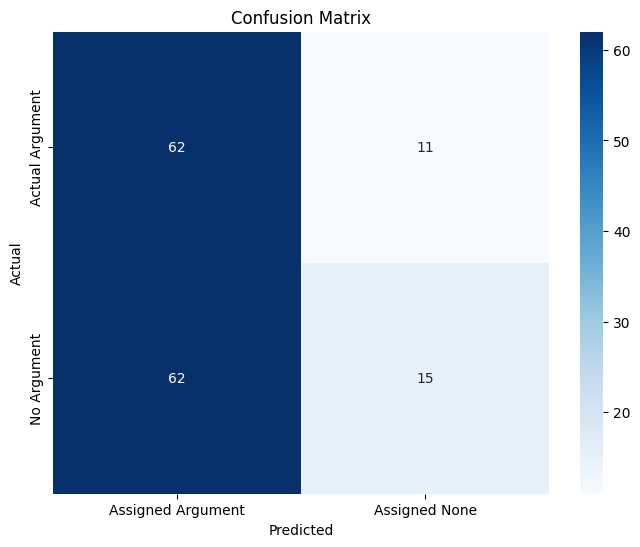

In [259]:

import matplotlib.pyplot as plt
import seaborn as sns  # optional for better heatmap visuals

# Data for the confusion matrix
confusion_data = {
    "Assigned Argument": [TP, FP],  # Predicted Argument Assigned
    "Assigned None": [FN, TN]       # Predicted None
}

confusion_matrix = pd.DataFrame(
    confusion_data, 
    index=["Actual Argument", "No Argument"]
)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Category Level

In [276]:
# Initialize counts
TP_category = 0  # True Positive
FP_category = 0  # False Positive
FN_category = 0  # False Negative
TN_category = 0  # True Negative

# Evaluate each row
for index, row in df_evaluation.iterrows():
    actual_category, predicted_category = row["actual_category"], row["predicted_category"]
    if actual_category == predicted_category and actual_category != "Unknown Category":
        TP_category += 1  # Correct argument assigned
    elif  actual_category == "Unknown Category" and predicted_category == "Unknown Category":
        TN_category += 1  # Argument was assigned when it was actual_categoryly None
    elif actual_category != "Unknown Category" and predicted_category == "Unknown Category":
        FN_category += 1  # No argument was assigned
    elif actual_category != predicted_category:
        FP_category += 1  # Wrong argument assigned


# Calculate precision_category, recall_category, and F1_category score
precision_category = TP_category / (TP_category + FP_category) if (TP_category + FP_category) > 0 else 0
recall_category = TP_category / (TP_category + FN_category) if (TP_category + FN_category) > 0 else 0
f1_category = 2 * (precision_category * recall_category) / (precision_category + recall_category) if (precision_category + recall_category) > 0 else 0

print(f"Precision_category: {precision_category}")
print(f"Recall_category: {recall_category}")
print(f"F1_category Score: {f1_category}")


Precision_category: 0.6434782608695652
Recall_category: 0.8409090909090909
F1_category Score: 0.729064039408867


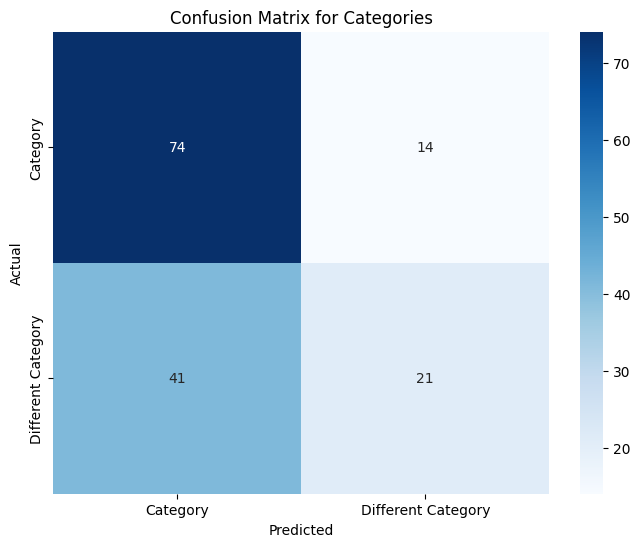

In [277]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Confusion matrix data
confusion_data_category = {
    "Category": [TP_category, FP_category],
    "Different Category": [FN_category, TN_category]    
}

# Create a DataFrame for the confusion matrix
confusion_matrix_category = pd.DataFrame(
    confusion_data_category, 
    index=["Category", "Different Category"]  # Row labels
)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_category, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.title("Confusion Matrix for Categories")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Testing Ende

In [ ]:
""""import json
from itertools import cycle

# Load API key
load_dotenv()

api_keys = [
    os.getenv("GROQ_API_KEY"),
    os.getenv("GROQ_API_KEY2"),
]

# Create a round-robin iterator for API keys
api_key_cycle = cycle(api_keys)

def get_next_api_key():
    return next(api_key_cycle)

def extract_arguments_and_sentiment(commentary):
    global list_of_arguments  # Ensure we can modify the global categories list

    current_api_key = get_next_api_key()
    
    # Call the find_arguments function with the selected API key
    result_json = find_arguments(commentary, current_api_key)   
    print(current_api_key) 

    try:
        # Parse the JSON response
        result_dict = json.loads(result_json)
        
        # Check for new categories and add them to the global list
        for category in result_dict.keys():
            if category not in list_of_arguments:
                list_of_arguments.append(category)  # Dynamically update the categories list
        
        time.sleep(4)
        return result_dict  # Return the result
    except json.JSONDecodeError:
        print("Failed to decode JSON response.")
        return None
""""

In [155]:
df_paragraphs_testing = df_paragraphs_testing[0:20]

In [156]:
df_paragraphs_testing

,Unnamed: 0,document_id,paragraph_id,paragraph
0,0,1,1,BUY INVESTMENT HIGHLIGHTS: $150.00 We raise ou...
1,1,1,2,revenue should reach approximately $6.663B up ...
2,2,1,3,We expect mobile ad revenue to represent appro...
3,3,1,4,We raise our estimates for FY16 as we expect a...
4,4,1,5,We raise our estimates for FY17 and now expect...
5,5,1,6,We are buyers of FB based on our belief that d...
6,6,1,7,Valuation Price Target: $150.00 Our $150 targe...
7,7,1,8,"FB is the largest social network, with 1.65B u..."
8,8,1,9,Risks to our thesis and target price include a...
9,9,2,1,FB reported relatively strong 2Q resultsrevenu...


In [157]:
df_paragraphs_testing["provided arguments"] = df_paragraphs_testing["paragraph"].apply(extract_arguments_and_sentiment)

Response: ChatCompletion(id='chatcmpl-24efb4c9-1bf2-420b-84e1-8892c63bdc5c', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"Revenue": "positive", "Earnings per Share": "positive"}', role='assistant', function_call=None, tool_calls=None))], created=1733736853, model='llama3-70b-8192', object='chat.completion', system_fingerprint='fp_753a4aecf6', usage=CompletionUsage(completion_tokens=16, prompt_tokens=513, total_tokens=529, completion_time=0.045714286, prompt_time=0.027305269, queue_time=0.008833845, total_time=0.073019555), x_groq={'id': 'req_01jenc9vg8f8rskpywz9g85k23'})
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
Response: ChatCompletion(id='chatcmpl-b29e09e2-dae5-425d-bc97-883239d8f825', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"Revenue": "positive"}', role='assistant', function_call=None, tool_calls=None))], created=1733736857, model='llama3-70b-8192', 

/var/folders/2h/tyzkflxs465698k6z8l3ktj00000gn/T/ipykernel_69688/2420103696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paragraphs_testing["provided arguments"] = df_paragraphs_testing["paragraph"].apply(extract_arguments_and_sentiment)


In [ ]:
df_paragraphs_testing.head()

,Unnamed: 0,document_id,paragraphs,paragraph_id
0,0,1,BUY INVESTMENT HIGHLIGHTS: $150.00 We raise ou...,1
1,1,1,revenue should reach approximately $6.663B up ...,2
2,2,1,We expect mobile ad revenue to represent appro...,3
3,3,1,We raise our estimates for FY16 as we expect a...,4
4,4,1,We raise our estimates for FY17 and now expect...,5


In [ ]:
#df_paragraphs_testing.to_csv("without_data_cleaning_test.csv")

In [ ]:
import pandas as pd
import ast

# Initialize a list to store the exploded rows
rows = []

# Iterate through the DataFrame and expand the dictionary into rows
for index, row in df_paragraphs_testing.iterrows():
    provided_args = row["provided arguments"]
    # Convert string to dictionary if needed
    if isinstance(provided_args, str):
        try:
            provided_args = ast.literal_eval(provided_args)  # Convert string to dictionary
        except (ValueError, SyntaxError):
            print(f"Invalid format for provided_args at index {index}: {provided_args}")
            continue  # Skip invalid entries

    # Ensure it's a dictionary
    if isinstance(provided_args, dict):
        #print(f"Processed provided_args: {provided_args}")
        for argument, sentiment in provided_args.items():
            rows.append({
                "ID": row["ID"],
                "Argument": argument,
                "Sentiment": sentiment
            })

# Create a new DataFrame from the exploded rows
df_result = pd.DataFrame(rows)

# Display the resulting DataFrame
print(df_result)

     ID             Argument Sentiment
0     1          Solid 1QF20  positive
1     1     Long-term Growth  positive
2     1  Channel Development  positive
3     1     Positive Traffic  positive
4     1   Buying Opportunity  positive
..   ..                  ...       ...
845  20     Market Expansion  positive
846  20        US EV credits  positive
847  20   raw material costs  negative
848  20        US regulation  negative
849  20      Model 3Y demand  negative

[850 rows x 3 columns]


In [ ]:
df_result.to_csv("list_of_arguments3.csv")

In [ ]:
df_result.info()

NameError: name 'df' is not defined

In [ ]:
import pandas as pd
import json
from collections import Counter, defaultdict

# Initialize a dictionary to hold counts for each key and sentiment
sentiment_counts = defaultdict(lambda: Counter({'positive': 0, 'neutral': 0, 'negative': 0}))

# Loop through each entry in the provided_arguments column
for entry in df_paragraphs_testing["provided arguments"]:
    # Ensure the entry is a dictionary
    if isinstance(entry, str):
        try:
            # Convert string to dictionary if it's in JSON-like format
            arguments_dict = json.loads(entry.replace("'", '"'))  # Replace single quotes with double quotes for JSON
        except json.JSONDecodeError:
            continue  # Skip any rows that can't be parsed as dictionaries
    elif isinstance(entry, dict):
        arguments_dict = entry
    else:
        continue  # Skip if entry is not a dictionary or parseable string

    # Update counts for each key and sentiment
    for key, sentiment in arguments_dict.items():
        sentiment_counts[key][sentiment] += 1

# Convert the result to a DataFrame for easier viewing
sentiment_overview_df = pd.DataFrame(sentiment_counts).T
sentiment_overview_df.columns = ["positive", "neutral", "negative"]
sentiment_overview_df.index.name = "Argument"

# Display the overview DataFrame
sentiment_overview_df.reset_index(inplace=True)
sentiment_overview_df.sort_values(by=["positive","negative","neutral"],ascending=False)


,Argument,positive,neutral,negative
5,Financial Guidance,6,2,0
0,Financial Performance,5,2,0
6,Share Repurchase,5,1,0
24,Revenue Growth,5,1,0
2,Capital Management,4,0,0
1,Dividend Policy,3,1,1
3,Earnings Guidance,3,1,0
10,Operational Efficiency,3,1,0
31,Product Strategy,3,1,0
32,Growth Strategy,3,0,0


# Check amount of intensifiers

In [ ]:

# Basic Intensifiers
basic_intensifiers = [
    "very", "really", "quite", "so", "too", "totally", "absolutely",
    "completely", "utterly", "entirely", "truly", "fully", "genuinely", "surely"
]

# Strong Intensifiers (includes previous stronger, superlative, and "all/full" intensifiers)
strong_intensifiers = [
    "extremely", "incredibly", "highly", "immensely", "vastly", "remarkably", 
    "tremendously", "phenomenally", "exceptionally", "noticeably", "supremely", 
    "powerfully", "acutely", "enormously", "greatly", "immeasurably", "infinitely",
    "wildly", "lavishly", "ludicrously", "fiercely", "ferociously", "intensely",
    "extraordinarily", "overwhelmingly", "staggeringly", "excessively", "insanely", 
    "unbelievably", "inconceivably", "ridiculously", "crazily", "all-out", 
    "all-around", "full-on", "fully", "flat-out"
]

# Formal/Emotive Intensifiers (combines emotive and formal language for a more academic or dramatic tone)
formal_emotive_intensifiers = [
    "profoundly", "considerably", "significantly", "markedly", "appreciably", 
    "notably", "exceedingly", "far", "deeply", "awfully", "horribly", "dreadfully", 
    "frightfully", "painfully", "absurdly", "scandalously", "outrageously", 
    "shockingly", "horrendously", "terribly", "hideously", "grossly"
]


In [ ]:
import re

# Function to count intensifiers in a single text
def count_intensifiers(text, intensifiers):
    # Convert to lowercase to make it case-insensitive
    words = re.findall(r'\b\w+\b', text.lower())
    return sum(words.count(word) for word in intensifiers)

In [ ]:
# Apply the function to the "Sentence" column of the DataFrame
df_paragraphs_testing["Basic Intensifier"] = df_paragraphs_testing["paragraphs"].apply(count_intensifiers, intensifiers=basic_intensifiers)
df_paragraphs_testing["Strong Intensifier"] = df_paragraphs_testing["paragraphs"].apply(count_intensifiers, intensifiers=strong_intensifiers)
df_paragraphs_testing["Formal Intensifier"] = df_paragraphs_testing["paragraphs"].apply(count_intensifiers, intensifiers=formal_emotive_intensifiers)

/var/folders/2h/tyzkflxs465698k6z8l3ktj00000gn/T/ipykernel_75223/694084076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paragraphs_testing["Basic Intensifier"] = df_paragraphs_testing["paragraphs"].apply(count_intensifiers, intensifiers=basic_intensifiers)
/var/folders/2h/tyzkflxs465698k6z8l3ktj00000gn/T/ipykernel_75223/694084076.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paragraphs_testing["Strong Intensifier"] = df_paragraphs_testing["paragraphs"].apply(count_intensifiers, intensifie

In [ ]:
df_paragraphs_testing

,Unnamed: 0,ID,paragraphs,provided arguments,Basic Intensifier,Strong Intensifier,Formal Intensifier
0,0,1,We maintain our Overweight rating and raise ou...,"{'Financial Performance': 'positive', 'Dividen...",0,0,0
1,1,1,We remain in the minority with less than a thi...,"{'Balance Sheet': 'negative', 'Dividend Policy...",1,0,0
2,2,1,"Adjustments reect Q3 2021 actuals, our updated...","{'Operational Efficiency': 'positive', 'Capita...",0,0,0
3,3,1,XOM expects upstream volumes to increase on lo...,"{'Operational Efficiency': 'neutral', 'Upstrea...",0,0,0
4,4,1,XOM announced a 10bn share repurchase Buybacks...,"{'Share Repurchase': 'positive', 'Dividend Pol...",0,0,0
5,5,1,XOM announced annual capex range of 2025bn goi...,"{'Capital Management': 'positive', 'Cost Struc...",1,1,0
6,6,1,EPS of 1.57 was in betweenour estimate of 1.58...,"{'Financial Performance': 'neutral', 'Operatio...",0,0,0
7,7,1,Our 75 price target is based on 6.5x our 2023 ...,"{'Valuation': 'neutral', 'Earnings Guidance': ...",0,0,0
8,8,1,Systematic risks to our targetrating include c...,"{'Regulatory Environment': 'negative', 'Operat...",0,0,0
9,9,1,XOM We have an Overweight rating on XOM. Opex ...,"{'Financial Performance': 'positive', 'Cost Ma...",0,0,0
